# Brain tumor 3D segmentation with MONAI

This tutorial shows how to construct a training workflow of multi-labels segmentation task.

And it contains below features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Deterministic training for reproducibility.

The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](../figures/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb)

## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch
from torch.utils.data import random_split
from tqdm import tqdm

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/90_source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import RandFourierDiskMaskd
from utils import show_slice_and_fourier
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'
print('root_dir', root_dir)
print_config()

device = torch.device("cuda:0")

root_dir /vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/
MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 1.15.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [2]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

## Setup transforms for each dataset

In [35]:
val_transform_baseline = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"])
    ]
)

val_transform_gibbs25 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandFourierDiskMaskd(keys='image', r=25 , inside_off=False, prob=1.)
    ]
)

val_transform_gibbs15 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandFourierDiskMaskd(keys='image', r=15 , inside_off=False, prob=1.)
    ]
)

val_transform_gibbs10 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandFourierDiskMaskd(keys='image', r=10 , inside_off=False, prob=1.)
    ]
)

## Load data with DecathlonDataset

In [4]:
# baseline
val_ds_baseline = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_baseline,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_baseline = random_split(val_ds_baseline, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_baseline = DataLoader(test_ds_baseline, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


In [6]:
#Gibbs25
val_ds_gibbs25 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_gibbs25,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)
_ , test_ds_gibbs25 = random_split(val_ds_gibbs25, [48, 48],
                                   torch.Generator().manual_seed(0))

test_loader_gibbs25 = DataLoader(test_ds_gibbs25, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


In [7]:
#Gibbs15
val_ds_gibbs15 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_gibbs15,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)
_ , test_ds_gibbs15 = random_split(val_ds_gibbs15, [48, 48],
                                   torch.Generator().manual_seed(0))

test_loader_gibbs15 = DataLoader(test_ds_gibbs15, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


In [36]:
# Gibb10
val_ds_gibbs10 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_gibbs10,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)
_ , test_ds_gibbs10 = random_split(val_ds_gibbs10, [48, 48],
                                   torch.Generator().manual_seed(0))

test_loader_gibbs10 = DataLoader(test_ds_gibbs10, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


## Check data shape and visualize

image shape: torch.Size([4, 128, 128, 64])


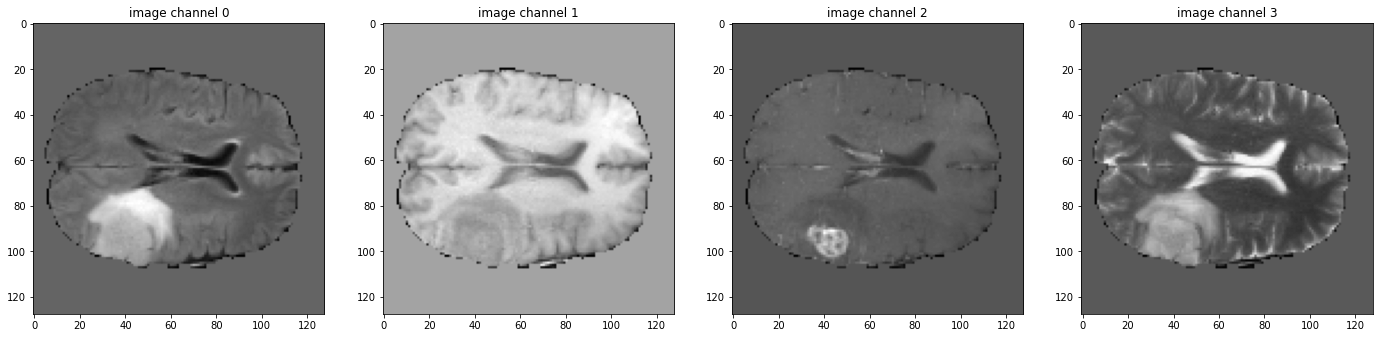

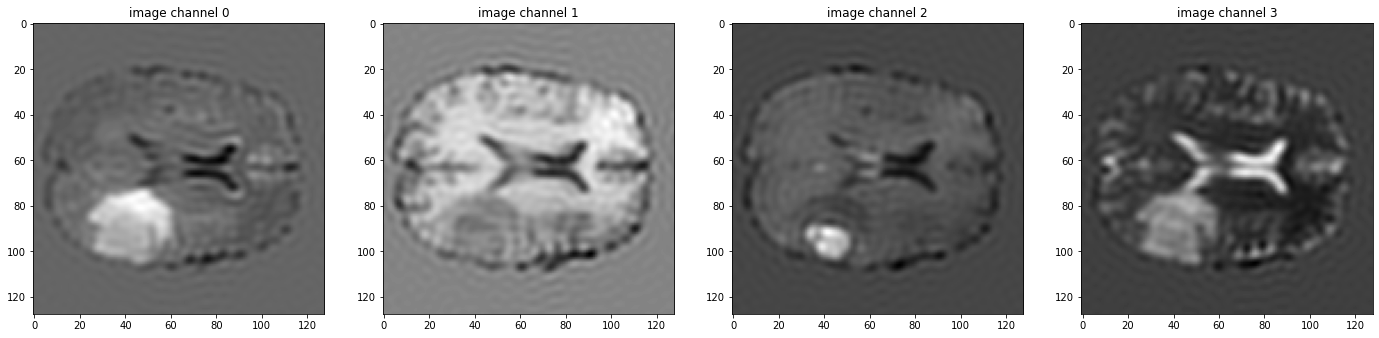

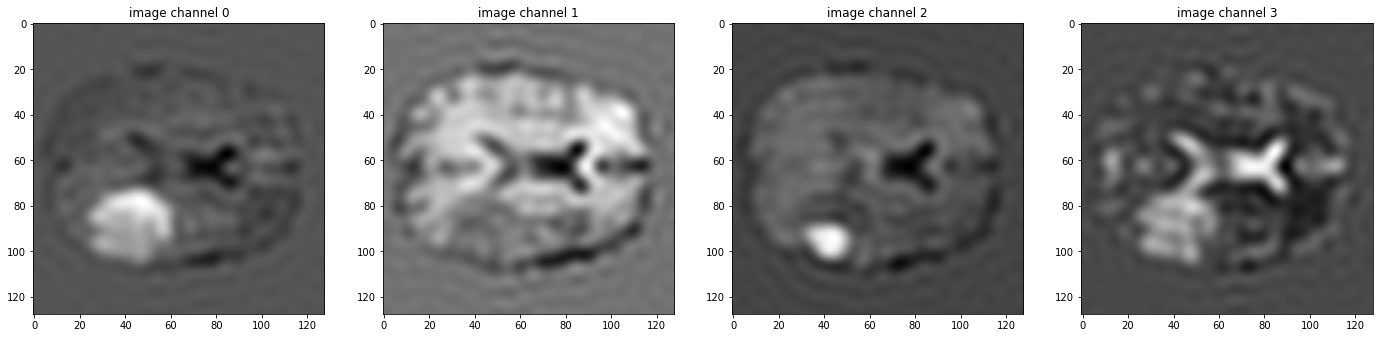

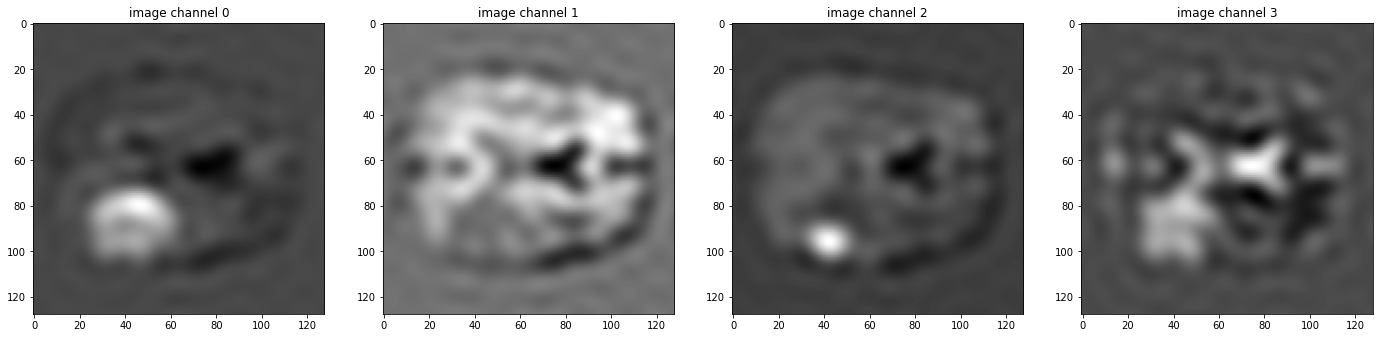

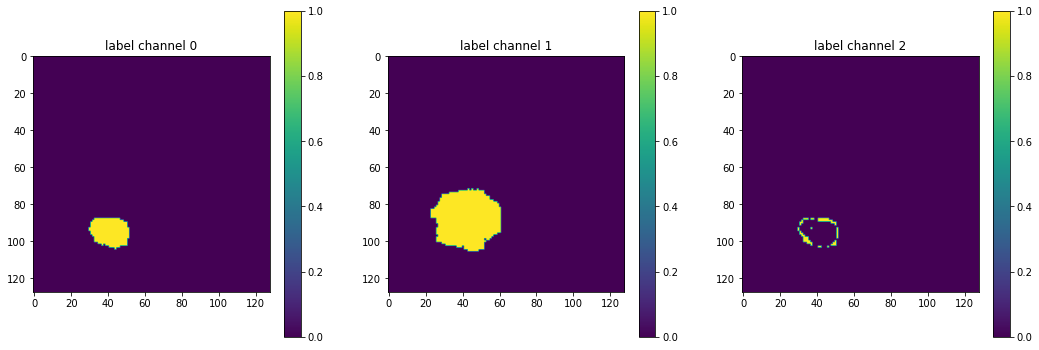

In [38]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
img_base = test_ds_baseline[20]['image']
img_gibbs25 = test_ds_gibbs25[20]['image']
img_gibbs15 = test_ds_gibbs15[20]['image']
img_gibbs10 = test_ds_gibbs10[20]['image']
label = test_ds_baseline[20]['label']

print(f"image shape: {img_base.shape}")
plt.figure('baseline',(24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(img_base[i, :, :, 32].detach().cpu(), cmap="gray")
plt.show()

plt.figure('gibbs25',(24,6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(img_gibbs25[i, :, :, 32].detach().cpu(), cmap="gray")
plt.show()
plt.figure('gibbs15',(24,6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(img_gibbs15[i, :, :, 32].detach().cpu(), cmap="gray")
plt.show()

plt.figure('gibbs10',(24,6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(img_gibbs10[i, :, :, 32].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(label[i, :, :, 32].detach().cpu())
    plt.colorbar()
plt.show()

# Inference

In [14]:
os.listdir(root_dir)

['Task01_BrainTumour',
 'best_metric_model_monai_data.pth',
 'best_metric_model_baseline.pth',
 'trainLoss_and_meanValScore_baseline.png',
 'meanValScore_per_label_baseline.png',
 'best_metric_model_Gibbs35.pth',
 'trainLoss_and_meanValScore_Gibbs35.png',
 'meanValScore_per_label_Gibbs35.png',
 'best_metric_model_Gibbs25.pth',
 'trainLoss_and_meanValScore_Gibbs25.png',
 'meanValScore_per_label_Gibbs25.png',
 'best_metric_model_Gibbs15.pth',
 'trainLoss_and_meanValScore_Gibbs15.png',
 'meanValScore_per_label_Gibbs15.png',
 'best_metric_model_Gibbs10.pth']

In [9]:
dice_metric = DiceMetric(include_background=True, reduction="mean")
post_trans = Compose([Activations(sigmoid=True),
                              AsDiscrete(threshold_values=True)])

In [16]:
from collections import defaultdict

class model_evaluation:
    '''Provides with regularly used tools
    
    Methods:
    
    * _load_UNet: loads instance of UNet model
    
    * dataset_eval: computes metrics on given dataset dataloader
    
    * add_eval: keeps record of metrics for given dataset
    
    '''
    
    def __init__(self, model_name):
    
        self.model_name = model_name
        self.model = self._load_UNet(model_name)
        self.eval_dict = defaultdict(list)
    
    
    def _load_UNet(self,model_name:str):
    
        '''Function to load model.
        Args: model_name = name of saved model.pth
        
        Returns: instance of UNet with imported weights'''

        model = UNet(dimensions=3, in_channels=4, out_channels=3, 
                     channels=(16, 32, 64, 128, 256), 
                     strides=(2, 2, 2, 2),
                     num_res_units=2,).to(device)
        model.load_state_dict(torch.load(root_dir+model_name))
        return model 
    
    
    def dataset_eval(self, test_loader:DataLoader):
        ''' To evaluate model on given data using Dice metric
        Args:
            test_data: test data loader
        Returns:
            mean metrics
        '''
        self.model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, reduction="mean")
            post_trans = Compose([Activations(sigmoid=True),
                                  AsDiscrete(threshold_values=True)])

            metric_sum = 0.
            metric_sum_tc = 0.
            metric_sum_wt = 0.
            metric_sum_et = 0.

            metric_count = 0
            metric_count_tc  = 0
            metric_count_wt = 0
            metric_count_et = 0

            for test_data in tqdm(test_loader):
                val_inputs, val_labels = (
                    test_data["image"].to(device),
                    test_data["label"].to(device),
                )
                val_outputs = self.model(val_inputs)
                val_outputs = post_trans(val_outputs)
                # compute overall mean dice
                value, not_nans = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = not_nans.item()
                metric_count += not_nans
                metric_sum += value.item() * not_nans
                # compute mean dice for TC
                value_tc, not_nans = dice_metric(
                    y_pred=val_outputs[:, 0:1], y=val_labels[:, 0:1]
                )
                not_nans = not_nans.item()
                metric_count_tc += not_nans
                metric_sum_tc += value_tc.item() * not_nans
                # compute mean dice for WT
                value_wt, not_nans = dice_metric(
                    y_pred=val_outputs[:, 1:2], y=val_labels[:, 1:2]
                )
                not_nans = not_nans.item()
                metric_count_wt += not_nans
                metric_sum_wt += value_wt.item() * not_nans
                # compute mean dice for ET
                value_et, not_nans = dice_metric(
                    y_pred=val_outputs[:, 2:3], y=val_labels[:, 2:3]
                )
                not_nans = not_nans.item()
                metric_count_et += not_nans
                metric_sum_et += value_et.item() * not_nans

            metric = metric_sum / metric_count
            metric_tc = metric_sum_tc / metric_count_tc
            metric_wt = metric_sum_wt / metric_count_wt
            metric_et = metric_sum_et / metric_count_et

        return metric, metric_et, metric_tc, metric_wt

    def add_eval(self, name:str, test_loader:DataLoader) -> None:
        '''Method to add evaluation to the attribute
        eval_dict.
        
        Args: 
            name = string to label evaluation
            test_loader = dataloader of data to test '''
        
        self.eval_dict[name] = self.dataset_eval(test_loader)



## Check models' output with the input image and label

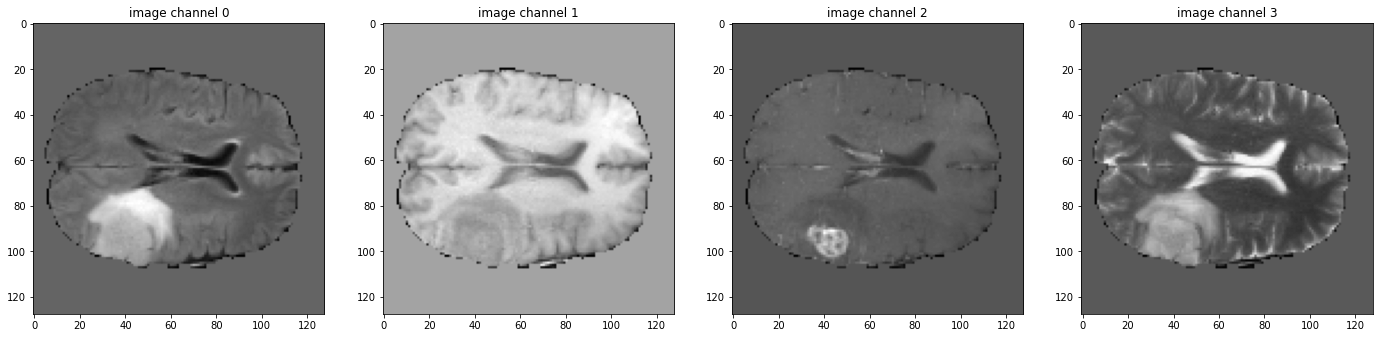

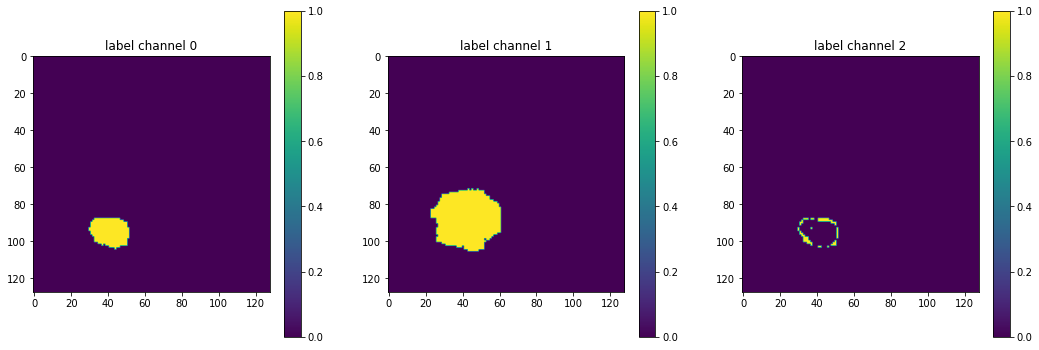

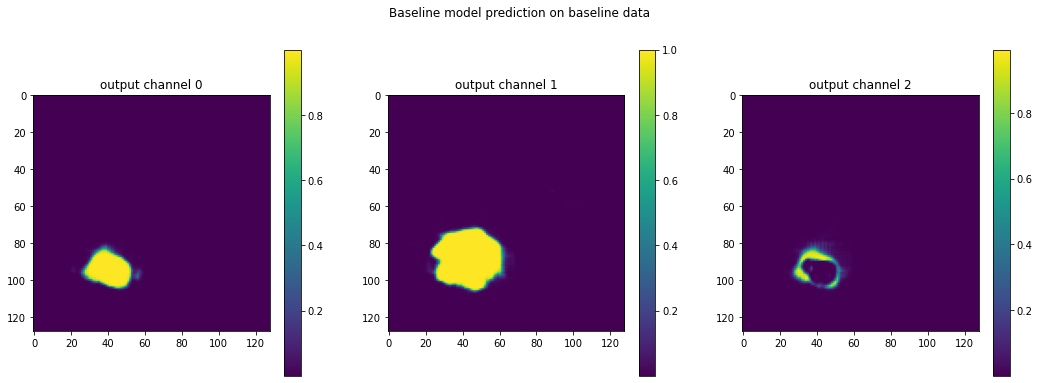

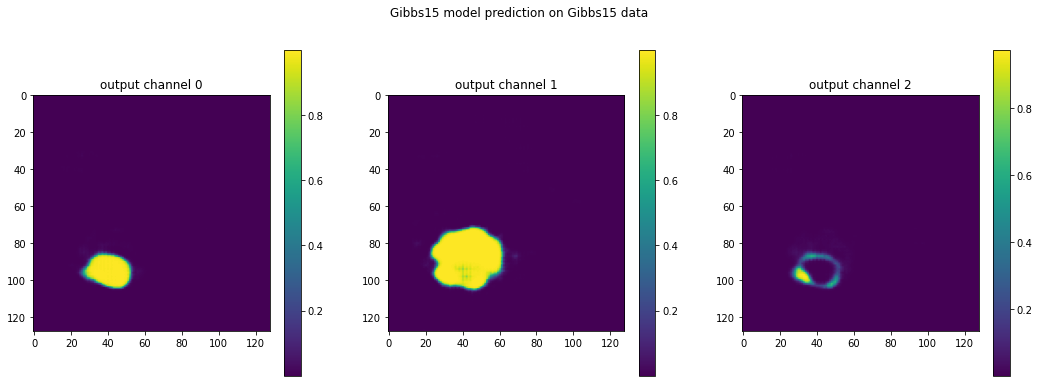

In [34]:
baseline.model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = img_base.unsqueeze(0).to(device)
    val_output = baseline.model(val_input)
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(img_base[i, :, :, 32].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(label[i, :, :, 32].detach().cpu())
        plt.colorbar()
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("baseline", (18, 6))
    plt.suptitle('Baseline model prediction on baseline data')
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(torch.sigmoid(val_output[0, i, :, :, 32].detach().cpu()))
        plt.colorbar()
    plt.show()
    
    # Gibbs15 model/data 
    gibbs15.model.eval()
    val_input = img_gibbs15.unsqueeze(0).to(device)
    val_output = gibbs15.model(val_input)
    plt.figure("gibbs15", (18, 6))
    plt.suptitle('Gibbs15 model prediction on Gibbs15 data')
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(torch.sigmoid(val_output[0, i, :, :, 32].detach().cpu()))
        plt.colorbar()
    plt.show()

## Model comparisons

In [21]:
# baseline.add_eval('baseline_data', test_loader_baseline)
baseline.add_eval('gibb25_data', test_loader_gibbs25)
baseline.add_eval('gibb15_data', test_loader_gibbs15)

100%|██████████| 24/24 [00:25<00:00,  1.05s/it]


In [25]:
baseline.eval_dict

defaultdict(list,
            {'baseline_data': (0.7432693392038345,
              0.5489715797205766,
              0.7797949202358723,
              0.9010415002703667),
             'gibb25_data': (0.7347966258724531,
              0.538196804622809,
              0.7712568901479244,
              0.8949361592531204),
             'gibb15_data': (0.7009676198164622,
              0.49333903441826504,
              0.7455974432329336,
              0.8639663631717364)})

In [26]:
gibbs15 = model_evaluation('best_metric_model_Gibbs15.pth')
gibbs15.add_eval('baseline_data', test_loader_baseline)
gibbs15.add_eval('gibbs15_data', test_loader_gibbs15)
gibbs15.add_eval('gibbs25_data', test_loader_gibbs25)

100%|██████████| 24/24 [00:30<00:00,  1.25s/it]


In [27]:
gibbs15.eval_dict

defaultdict(list,
            {'baseline_data': (0.7263649304707845,
              0.5140663217753172,
              0.7749898508191109,
              0.8900386467576027),
             'gibbs15_data': (0.727669378121694,
              0.5155740094681581,
              0.7781502865254879,
              0.8892838036020597),
             'gibbs25_data': (0.7359683538476626,
              0.5290654251972834,
              0.7839296087622643,
              0.8949100275834402)})